In [ ]:
from langchain.llms import OpenAI
from langchain.chat_models import ChatOpenAI
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.prompts import PromptTemplate
from langchain.output_parsers import PydanticOutputParser
from langchain.document_loaders import TextLoader
from langchain.text_splitter import CharacterTextSplitter
from langchain.vectorstores import FAISS, Pinecone
from langchain.document_loaders import WebBaseLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import Chroma
from langchain.chains import LLMChain, RetrievalQAWithSourcesChain
from langchain.retrievers.multi_query import MultiQueryRetriever
from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import LLMChainExtractor
from langchain.retrievers.document_compressors import LLMChainFilter
from langchain.retrievers import BM25Retriever, EnsembleRetriever
from langchain.retrievers import ParentDocumentRetriever
from langchain.storage import InMemoryStore
from langchain.retrievers.self_query.base import SelfQueryRetriever
from langchain.chains.query_constructor.base import AttributeInfo
from langchain.retrievers.web_research import WebResearchRetriever
from langchain.utilities import GoogleSearchAPIWrapper
from langchain.schema import Document

import os
import pinecone
from pydantic import BaseModel, Field
from typing import List

## Retrievers

A retriever is an interface that returns documents given an unstructured query. It is more general than a vector store. A retriever does not need to be able to store documents, only to return (or retrieve) them.

## MultiQueryRetriever

Distance-based vector database retrieval embeds (represents) queries in high-dimensional space and finds similar embedded documents based on "distance". But, retrieval may produce different results with subtle changes in query wording or if the embeddings do not capture the semantics of the data well. Prompt engineering / tuning is sometimes done to manually address these problems, but can be tedious. The `MultiQueryRetriever` automates the process of prompt tuning by using an LLM to generate multiple queries from different perspectives for a given user input query

In [ ]:
# Load blog post
loader = WebBaseLoader("https://lilianweng.github.io/posts/2023-06-23-agent/")
data = loader.load()

# Split
text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=0)
splits = text_splitter.split_documents(data)

# VectorDB
embedding = OpenAIEmbeddings(openai_api_key=open("openai_api.txt", 'r').read())
vectordb = Chroma.from_documents(documents=splits, embedding=embedding)

In [ ]:
question = "What are the approaches to Task Decomposition?"
llm = ChatOpenAI(temperature=0, openai_api_key=open("openai_api.txt", 'r').read())

retriever_from_llm = MultiQueryRetriever.from_llm(
    retriever=vectordb.as_retriever(), llm=llm
)

You can also supply a prompt along with an output parser to split the results into a list of queries.

In [ ]:
# Output parser will split the LLM result into a list of queries
class LineList(BaseModel):
    # "lines" is the key (attribute name) of the parsed output
    lines: List[str] = Field(description="Lines of text")


class LineListOutputParser(PydanticOutputParser):
    def __init__(self) -> None:
        super().__init__(pydantic_object=LineList)

    def parse(self, text: str) -> LineList:
        lines = text.strip().split("\n")
        return LineList(lines=lines)


output_parser = LineListOutputParser()

QUERY_PROMPT = PromptTemplate(
    input_variables=["question"],
    template="""You are an AI language model assistant. Your task is to generate five
    different versions of the given user question to retrieve relevant documents from a vector
    database. By generating multiple perspectives on the user question, your goal is to help
    the user overcome some of the limitations of the distance-based similarity search.
    Provide these alternative questions separated by newlines.
    Original question: {question}""",
)
llm = ChatOpenAI(temperature=0, openai_api_key=open("openai_api.txt", 'r').read())

# Chain
llm_chain = LLMChain(llm=llm, prompt=QUERY_PROMPT, output_parser=output_parser)

# Other inputs
question = "What are the approaches to Task Decomposition?"

In [ ]:
# Run
retriever = MultiQueryRetriever(
    retriever=vectordb.as_retriever(), llm_chain=llm_chain, parser_key="lines"
)  # "lines" is the key (attribute name) of the parsed output

# Results
unique_docs = retriever.get_relevant_documents(
    query="What does the course say about regression?"
)
len(unique_docs)

## Contextual Compression

One challenge with retrieval is that usually you don't know the specific queries your document storage system will face when you ingest data into the system. This means that the information most relevant to a query may be buried in a document with a lot of irrelevant text. Passing that full document through your application can lead to more expensive LLM calls and poorer responses.

Contextual compression is meant to fix this. The idea is simple: instead of immediately returning retrieved documents as-is, you can compress them using the context of the given query, so that only the relevant information is returned.

To use the Contextual Compression Retriever, you'll need:
* a base retriever
* a Document Compressor

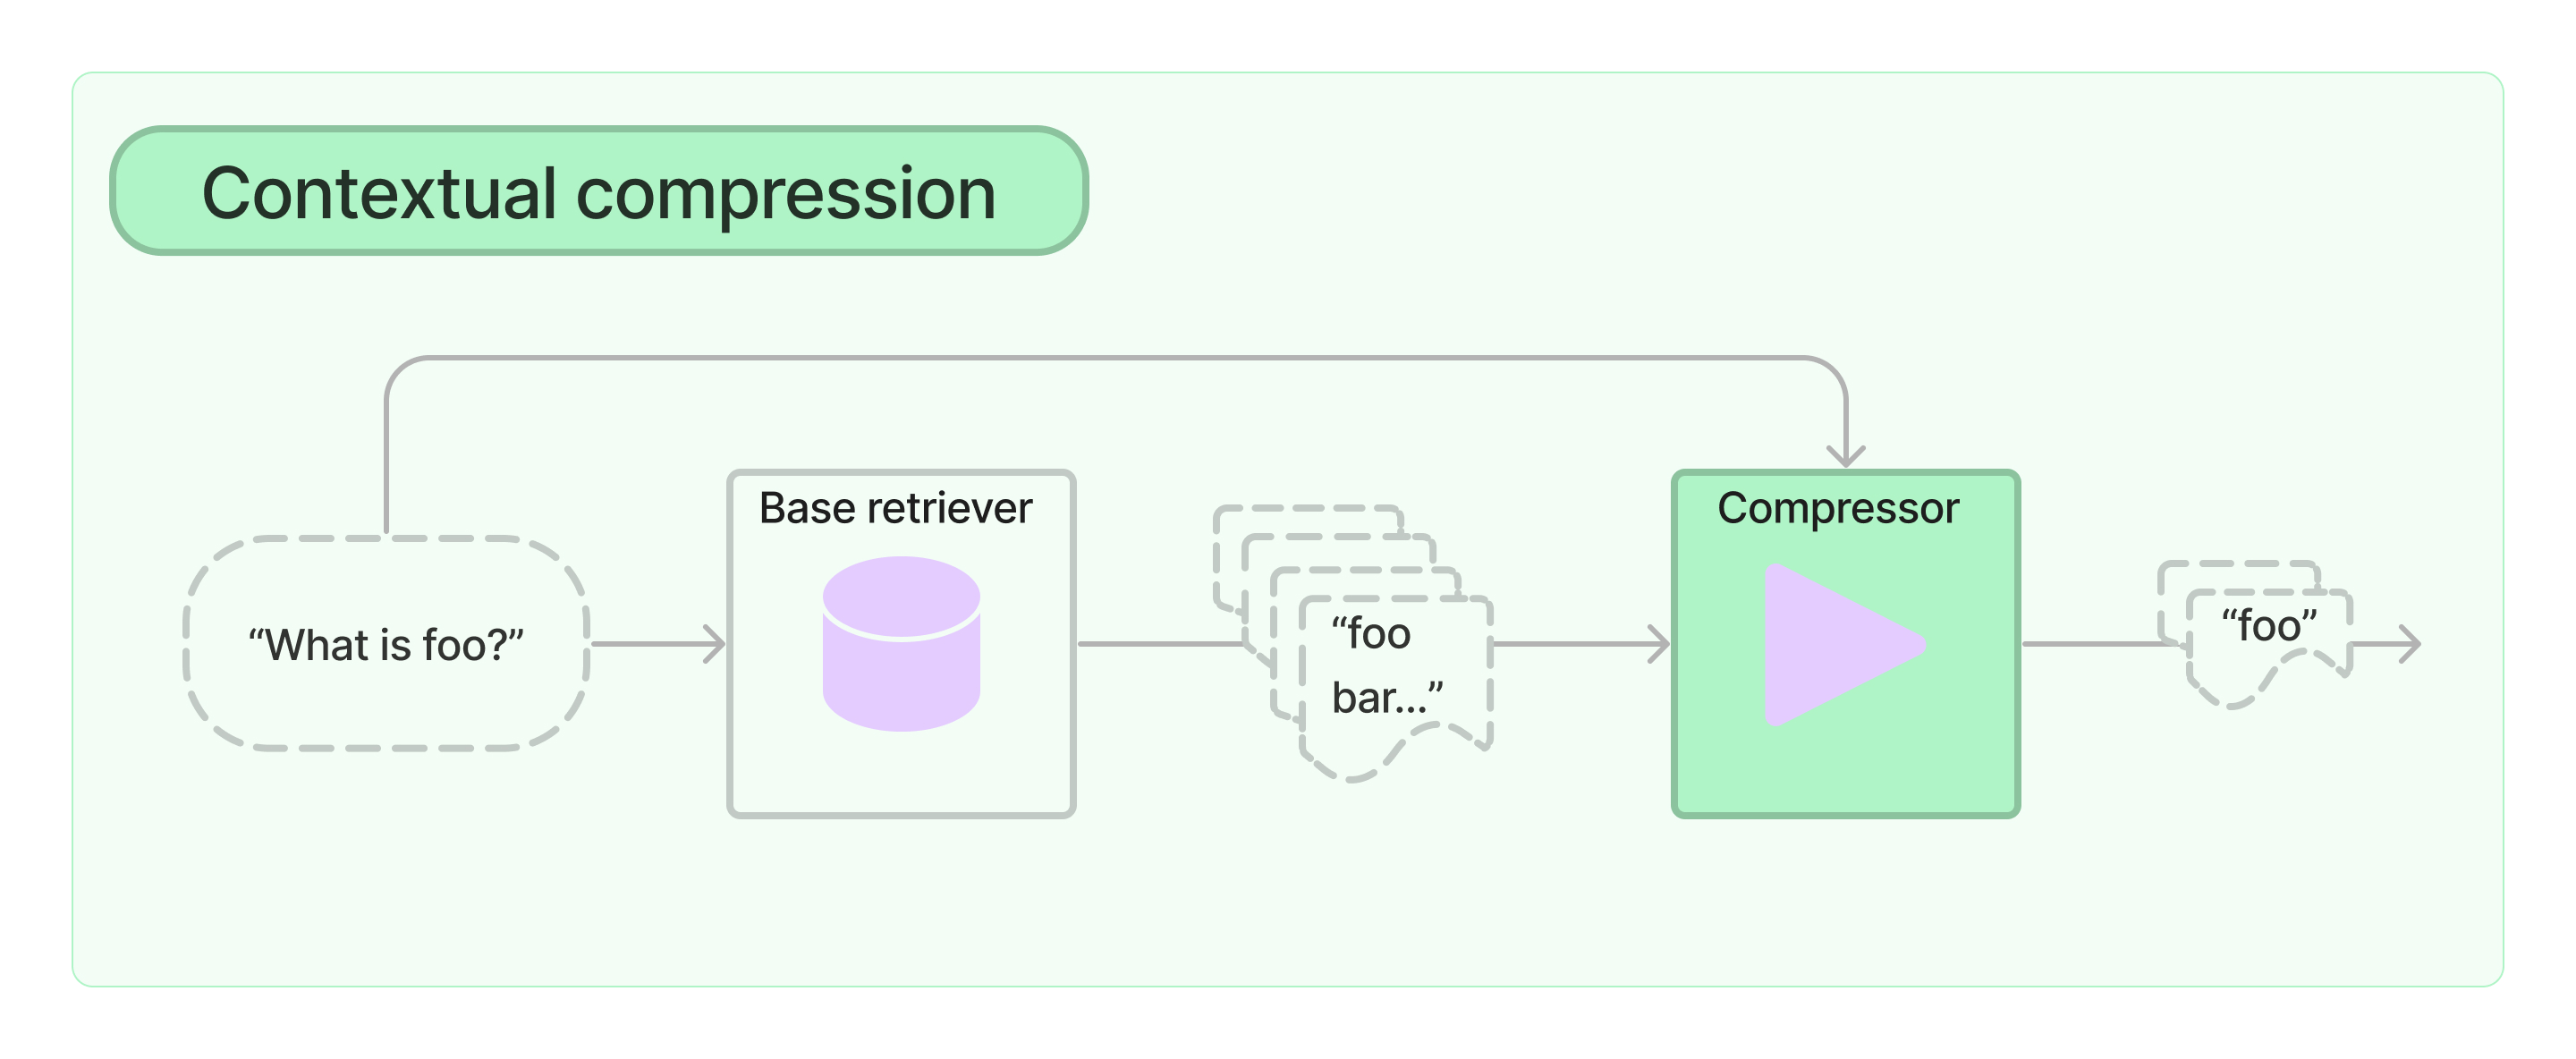

In [ ]:
# Helper function for printing docs

def pretty_print_docs(docs):
    print(f"\n{'-' * 100}\n".join([f"Document {i+1}:\n\n" + d.page_content for i, d in enumerate(docs)]))

In [ ]:
documents = TextLoader("state_of_the_union.txt").load()
text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=0)
texts = text_splitter.split_documents(documents)
retriever = FAISS.from_documents(texts, OpenAIEmbeddings()).as_retriever()

docs = retriever.get_relevant_documents("What did the president say about Ketanji Brown Jackson")
pretty_print_docs(docs)

In [ ]:
## Adding Contectual Compression

llm = OpenAI(temperature=0)
compressor = LLMChainExtractor.from_llm(llm)
compression_retriever = ContextualCompressionRetriever(base_compressor=compressor, base_retriever=retriever)

compressed_docs = compression_retriever.get_relevant_documents("What did the president say about Ketanji Jackson Brown")
pretty_print_docs(compressed_docs)

In [ ]:
_filter = LLMChainFilter.from_llm(llm)
compression_retriever = ContextualCompressionRetriever(base_compressor=_filter, base_retriever=retriever)

compressed_docs = compression_retriever.get_relevant_documents("What did the president say about Ketanji Jackson Brown")
pretty_print_docs(compressed_docs)

## Ensemble Retriever

The EnsembleRetriever takes a list of retrievers as input and ensemble the results of their get_relevant_documents() methods and rerank the results based on the Reciprocal Rank Fusion algorithm.

By leveraging the strengths of different algorithms, the EnsembleRetriever can achieve better performance than any single algorithm.

The most common pattern is to combine a sparse retriever (like BM25) with a dense retriever (like embedding similarity), because their strengths are complementary. It is also known as "hybrid search". The sparse retriever is good at finding relevant documents based on keywords, while the dense retriever is good at finding relevant documents based on semantic similarity.

In [ ]:
doc_list = [
    "I like apples",
    "I like oranges",
    "Apples and oranges are fruits",
]

# initialize the bm25 retriever and faiss retriever
bm25_retriever = BM25Retriever.from_texts(doc_list)
bm25_retriever.k = 2

embedding = OpenAIEmbeddings(openai_api_key=open("openai_api.txt", 'r').read())
faiss_vectorstore = FAISS.from_texts(doc_list, embedding)
faiss_retriever = faiss_vectorstore.as_retriever(search_kwargs={"k": 2})

# initialize the ensemble retriever
ensemble_retriever = EnsembleRetriever(retrievers=[bm25_retriever, faiss_retriever], weights=[0.5, 0.5])

docs = ensemble_retriever.get_relevant_documents("apples")
docs

## Parent Document Retriever

When splitting documents for retrieval, there are often conflicting desires:
1. You may want to have small documents, so that their embeddings can most accurately reflect their meaning. If too long, then the embeddings can lose meaning.
2. You want to have long enough documents that the context of each chunk is retained.

The `ParentDocumentRetriever` strikes that balance by splitting and storing small chunks of data. During retrieval, it first fetches the small chunks but then looks up the parent ids for those chunks and returns those larger documents.

In [ ]:
# Load Documents
loaders = [
    TextLoader('../../paul_graham_essay.txt'),
    TextLoader('../../state_of_the_union.txt'),
]
docs = []
for l in loaders:
    docs.extend(l.load())

# This text splitter is used to create the child documents
child_splitter = RecursiveCharacterTextSplitter(chunk_size=400)

# The vectorstore to use to index the child chunks
vectorstore = Chroma(
    collection_name="full_documents",
    embedding_function=OpenAIEmbeddings()
)

# The storage layer for the parent documents
store = InMemoryStore()
retriever = ParentDocumentRetriever(
    vectorstore=vectorstore,
    docstore=store,
    child_splitter=child_splitter,
)

# Adding the Documents
retriever.add_documents(docs, ids=None)

# Starting with Smaller chunks
sub_docs = vectorstore.similarity_search("justice breyer")
print(sub_docs[0].page_content)

# Overall Retriever
retrieved_docs = retriever.get_relevant_documents("justice breyer")

Sometimes, the full documents can be too big to want to retrieve them as is. In that case, what we really want to do is to first split the raw documents into larger chunks, and then split it into smaller chunks. We then index the smaller chunks, but on retrieval we retrieve the larger chunks (but still not the full documents).

In [ ]:
# This text splitter is used to create the parent documents
parent_splitter = RecursiveCharacterTextSplitter(chunk_size=2000)

# This text splitter is used to create the child documents (It should create documents smaller than the parent)
child_splitter = RecursiveCharacterTextSplitter(chunk_size=400)

# The vectorstore to use to index the child chunks
vectorstore = Chroma(collection_name="split_parents", embedding_function=OpenAIEmbeddings())

# The storage layer for the parent documents
store = InMemoryStore()

# Creating the Retriver
retriever = ParentDocumentRetriever(
    vectorstore=vectorstore,
    docstore=store,
    child_splitter=child_splitter,
    parent_splitter=parent_splitter
)

# Adding Documents
retriever.add_documents(docs)

sub_docs = vectorstore.similarity_search("justice breyer")

retrieved_docs = retriever.get_relevant_documents("justice breyer")

## Self-Querying

A self-querying retriever is one that, as the name suggests, has the ability to query itself. Specifically, given any natural language query, the retriever uses a query-constructing LLM chain to write a structured query and then applies that structured query to its underlying VectorStore. This allows the retriever to not only use the user-input query for semantic similarity comparison with the contents of stored documents but to also extract filters from the user query on the metadata of stored documents and to execute those filters.

In [ ]:
pinecone.init(api_key=os.environ["PINECONE_API_KEY"], environment=os.environ["PINECONE_ENV"])

embeddings = OpenAIEmbeddings()
# create new index
pinecone.create_index("langchain-self-retriever-demo", dimension=1536)

# Creating the Documents and the Vectorstore
docs = [
    Document(page_content="A bunch of scientists bring back dinosaurs and mayhem breaks loose", metadata={"year": 1993, "rating": 7.7, "genre": ["action", "science fiction"]}),
    Document(page_content="Leo DiCaprio gets lost in a dream within a dream within a dream within a ...", metadata={"year": 2010, "director": "Christopher Nolan", "rating": 8.2}),
    Document(page_content="A psychologist / detective gets lost in a series of dreams within dreams within dreams and Inception reused the idea", metadata={"year": 2006, "director": "Satoshi Kon", "rating": 8.6}),
    Document(page_content="A bunch of normal-sized women are supremely wholesome and some men pine after them", metadata={"year": 2019, "director": "Greta Gerwig", "rating": 8.3}),
    Document(page_content="Toys come alive and have a blast doing so", metadata={"year": 1995, "genre": "animated"}),
    Document(page_content="Three men walk into the Zone, three men walk out of the Zone", metadata={"year": 1979, "rating": 9.9, "director": "Andrei Tarkovsky", "genre": ["science fiction", "thriller"], "rating": 9.9})
]
vectorstore = Pinecone.from_documents(
    docs, embeddings, index_name="langchain-self-retriever-demo"
)

Now we can instantiate our retriever. To do this we'll need to provide some information upfront about the metadata fields that our documents support and a short description of the document contents.

In [ ]:
metadata_field_info=[
    AttributeInfo(
        name="genre",
        description="The genre of the movie",
        type="string or list[string]",
    ),
    AttributeInfo(
        name="year",
        description="The year the movie was released",
        type="integer",
    ),
    AttributeInfo(
        name="director",
        description="The name of the movie director",
        type="string",
    ),
    AttributeInfo(
        name="rating",
        description="A 1-10 rating for the movie",
        type="float"
    ),
]
document_content_description = "Brief summary of a movie"
llm = OpenAI(temperature=0)
retriever = SelfQueryRetriever.from_llm(llm, vectorstore, document_content_description, metadata_field_info, verbose=True)

In [ ]:
# This example only specifies a relevant query
retriever.get_relevant_documents("What are some movies about dinosaurs")

In [ ]:
# This example only specifies a filter
retriever.get_relevant_documents("I want to watch a movie rated higher than 8.5")

In [ ]:
# This example specifies a query and a filter
retriever.get_relevant_documents("Has Greta Gerwig directed any movies about women")

In [ ]:
# This example specifies a composite filter
retriever.get_relevant_documents("What's a highly rated (above 8.5) science fiction film?")

In [ ]:
# This example specifies a query and composite filter
retriever.get_relevant_documents("What's a movie after 1990 but before 2005 that's all about toys, and preferably is animated")

## WebResearchRetriever

Given a query, this retriever will:
* Formulate a set of relate Google searches
* Search for each
* Load all the resulting URLs
* Then embed and perform similarity search with the query on the consolidate page content

In [ ]:
# Vectorstore
vectorstore = Chroma(embedding_function=OpenAIEmbeddings(), persist_directory="./chroma_db_oai")

# LLM
llm = ChatOpenAI(temperature=0)

# Search
os.environ["GOOGLE_CSE_ID"] = "xxx"
os.environ["GOOGLE_API_KEY"] = "xxx"
search = GoogleSearchAPIWrapper()

# Initialize
web_research_retriever = WebResearchRetriever.from_llm(
    vectorstore=vectorstore,
    llm=llm,
    search=search
)

user_input = "How do LLM Powered Autonomous Agents work?"
qa_chain = RetrievalQAWithSourcesChain.from_chain_type(llm,retriever=web_research_retriever)
result = qa_chain({"question": user_input})
result